In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spock import FeatureClassifier
import rebound
%matplotlib inline

In [2]:
def makesim(P1, P2):
    ecc1, ecc0, ecc2 = 0.1, 0.07, 0.1
    mu1, mu2 = 36e-6, 28e-6
    pomega1, pomega0, pomega2 = -0.4, -0.86, 0
    P_0, lambda_0 = 0.05, 0

    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc0, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    return sim

In [3]:
def get_sims(xlist, ylist):
    sims = []
    for y in ylist:
        for x in xlist:
            sims.append(makesim(x, y))
    return sims
            
def get_centered_grid(xlist, ylist, probs):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(probs).reshape(len(ylist),len(xlist))

    return X,Y,Z

In [4]:
Ngrid_x = 100
Ngrid_y = 100
P_0 = 0.05

P1 = np.linspace(0.49*P_0,0.76*P_0,Ngrid_x)
P2 = np.linspace(1.3*P_0,2.04*P_0,Ngrid_y)

In [ ]:
%%time
model = FeatureClassifier()
sims = get_sims(P1, P2)
probs = model.predict_stable(sims)

[13:33:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


Text(0, 0.5, '$P_2$ [$P$]')

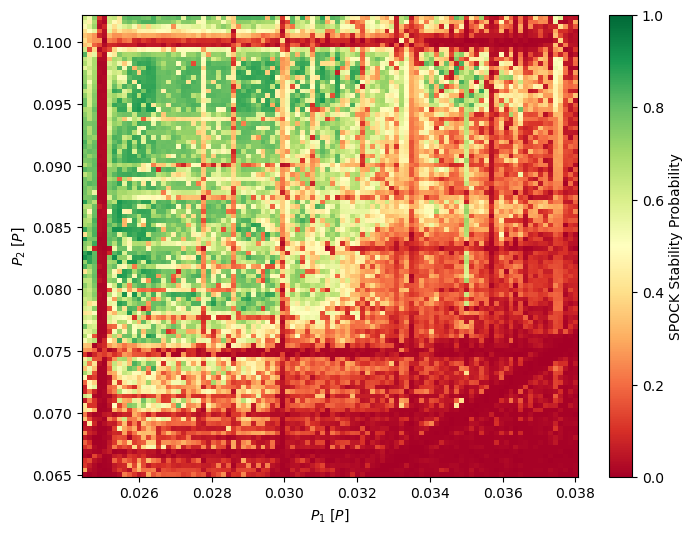

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

X,Y,Z = get_centered_grid(P1, P2, probs)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="RdYlGn")

cb = plt.colorbar(im, ax=ax)
cb.set_label("SPOCK Stability Probability")
ax.set_xlabel(r"$P_1$ [$P$]")
ax.set_ylabel(r"$P_2$ [$P$]")